# DDPG (Deep Deterministic Policy Gradient)

### 0.Backgroud: from discrete action into continuous action
In reinforcement learning, the action space can be either discrete or continuous. Discrete action spaces involve a finite set of actions that an agent can choose from, while continuous action spaces allow for a range of possible actions. 

Deep Deterministic Policy Gradient (DDPG) is a reinforcement learning algorithm designed for continuous action spaces. Unlike discrete action methods like DQN, which rely on enumerating all possible actions to find the optimal one, DDPG handles the challenge of continuous actions by combining elements of Actor-Critic and deterministic policy approaches.

- **Action Space**: DDPG operates in continuous action spaces, where actions can take infinite values within a defined range (e.g., [-1, 1] for each action dimension). This makes it suitable for tasks like robotic control or autonomous driving.
- **Deterministic Policy**: The Actor network outputs a specific action $a$ for a given state $s$, rather than a probability distribution over actions. This avoids the need for sampling and directly approximates the action that maximizes the Q-value.
- **Critic Network**: The Critic network evaluates the quality of actions by estimating the Q-value $Q(s, a)$. It provides feedback to the Actor network, guiding it to improve its action outputs.
- **Objective**: The Actor network learns to approximate $\text{argmax}_a Q(s, a)$, i.e., selecting the action that maximizes the Q-value for a given state. Instead of explicitly searching the continuous action space, the Actor network uses gradient-based optimization to refine its output.

- **Training Process**:
  1. The Critic network is trained to predict $Q(s, a)$ values for given state-action pairs.
  2. The Actor network is trained using the gradient of the Q-value with respect to the actions, effectively learning to output actions that maximize the Q-value.

DDPG's ability to handle continuous action spaces makes it a powerful algorithm for control tasks, where discrete action methods like DQN are not applicable. The Actor-Critic architecture and deterministic policy design enable efficient learning and decision-making in high-dimensional environments.

### 1. Import the Necessary Packages

In this notebook, we will implement a DDPG agent with OpenAI Gym's [Pendulum-v1](https://gymnasium.farama.org/environments/classic_control/pendulum/) environment.

In [61]:
import random
import numpy as np

from collections import namedtuple, deque
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# for game rendering
import time
from PIL import Image
from IPython import display


device = torch.device("cuda:0" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")
print(f"Training on: {device}")

%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=3, linewidth=120)

Training on: mps


### 2. Explore Environment

<div style="text-align: center;">
    <img src="./images/pendulum.gif" alt="Mountain Car Environment" width="10%">
</div>

#### Task Goal
The goal of the Pendulum environment is to stabilize a pendulum in an upright position by applying continuous torque. The pendulum starts in a random position and velocity, and the agent must learn to apply the appropriate torque to minimize the following cost function:

$$
\text{Cost} = \theta^2 + 0.1 \cdot \dot{\theta}^2 + 0.001 \cdot \text{torque}^2
$$

Where:
- $\theta$ is the angle of the pendulum from the upright position (in radians).
- $\dot{\theta}$ is the angular velocity of the pendulum.
- $\text{torque}$ is the control input applied by the agent.

The agent aims to minimize this cost by balancing the pendulum upright with minimal oscillations and energy expenditure.

#### Action Space
| Num | Action  | Min  | Max  |
|-----|---------|------|------|
| 0   | Torque  | -2.0 |  2.0 |

The action is a `ndarray` with shape `(1,)`, representing the torque applied to the free end of the pendulum.

---

#### Observation Space
| Num | Observation      | Min  | Max  |
|-----|------------------|------|------|
| 0   | $x = \cos(\theta)$ | -1.0 |  1.0 |
| 1   | $y = \sin(\theta)$ | -1.0 |  1.0 |
| 2   | Angular Velocity  | -8.0 |  8.0 |

The observation is a `ndarray` with shape `(3,)`, representing:
- The x-y coordinates of the pendulum’s free end ($\cos(\theta)$, $\sin(\theta)$).
- The angular velocity of the pendulum.


In [ ]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

# Explore state (observation) space
print("State space:\n", env.observation_space)
print(" - low:", env.observation_space.low)
print(" - high:", env.observation_space.high)

# Explore action space
print("Action space:\n", env.action_space)

print("-" * 50)
# Generate some samples from the state space
print("State space 2 samples:")
print(np.array([env.observation_space.sample() for i in range(2)]))

# Generate some samples from the action space
print("Action space 2 samples:")
print(np.array([env.action_space.sample() for i in range(2)]))

State space:
 Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
 - low: [-1. -1. -8.]
 - high: [1. 1. 8.]
Action space:
 Box(-2.0, 2.0, (1,), float32)
--------------------------------------------------
State space 2 samples:
[[-0.683 -0.456 -7.912]
 [-0.587 -0.649  6.202]]
Action space 2 samples:
[[-1.559]
 [-0.613]]


### 3. Define Replay Buffer

It's like DQN, we will use a replay buffer in DDPG to store the transitions. The replay buffer is a key component of many reinforcement learning algorithms, including DQN and DDPG. It helps to stabilize the learning process and improve the agent's performance over time.

<div style="text-align: center;">
    <img src="./images/reply-buffer.png" alt="Mountain Car Environment" width="50%">
</div>

When an agent interacts with the environment, the sequence of experience tuples can be highly correlated, which poses a risk for naive Q-learning algorithms. These algorithms, when learning sequentially from such correlated data, may lead to unstable updates, causing action values to oscillate or diverge.

To address this, a replay buffer is introduced to store experience tuples $(S, A, R, S')$ collected during interactions with the environment. By using **experience replay**, small batches of tuples are randomly sampled from the buffer for training. This random sampling breaks harmful correlations, stabilizes learning, and allows the agent to:  
1. Reuse individual experience tuples multiple times.  
2. Recall rare events.  
3. Make better overall use of past experiences.  

Experience replay thus improves the efficiency and stability of the learning process.

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            batch_size (int): size of each training batch
            buffer_size (int): maximum size of buffer
            seed (int): random seed
        """
        self.action_size = action_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple(
            "Experience",
            field_names=["state", "action", "reward", "next_state", "done"],
        )
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def _to_tensor(self, data, dtype=torch.float):
        """Convert numpy array to tensor with specified dtype and device in one operation"""
        return torch.from_numpy(np.vstack(data)).to(device=device, dtype=dtype)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""

        experiences = random.sample(self.memory, k=self.batch_size)
        experiences = [e for e in experiences if e is not None]
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = self._to_tensor(states)
        actions = self._to_tensor(actions, dtype=torch.long)
        rewards = self._to_tensor(rewards)
        next_states = self._to_tensor(next_states)
        dones = self._to_tensor(dones, dtype=torch.uint8)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
# Simulate Experience Replay How to Works
buffer = ReplayBuffer(
    action_size=env.action_space.shape[0], buffer_size=10, batch_size=2, seed=42
)
state, _ = env.reset()
for i in range(5):
    action = env.action_space.sample()
    next_state, reward, done, _, _ = env.step(action)
    buffer.add(state, action, reward, next_state, done)
print(f"Current Buffer Size: {len(buffer)}")
print("Sample one batch:")
batches = buffer.sample()
states, actions, rewards, next_states, dones = batches
print(
    f" States Size: {states.shape}, \n Actions Size: {actions.shape}, "
    f"\n Rewards Size: {rewards.shape}, \n Next States Size: {next_states.shape}"
    f"\n Dones Size: {dones.shape}"
)

Current Buffer Size: 5
Sample one batch:
 States Size: torch.Size([2, 3]), 
 Actions Size: torch.Size([2, 1]), 
 Rewards Size: torch.Size([2, 1]), 
 Next States Size: torch.Size([2, 3])
 Dones Size: torch.Size([2, 1])


### 4. Define Actor Network

<div style="display: flex; align-items: center; justify-content: center;">
    <img src="./images/ddpg_actor.png" alt="Mountain Car Environment" width="45%">
    <div style="border-left: 2px solid #ccc; height: 300px; margin: 0 20px;"></div>
    <img src="./images/ddpg_critic.png" alt="Mountain Car Environment" width="45%">
</div>


#### Weight Initialization

- Final Layer Initialization
    - **Low-dimensional case**:
    - Uniform distribution: $-3 × 10^{-3}, 3 × 10^{-3}$
    - **Pixel case**:
    - Uniform distribution: $-3 × 10^{-4}, 3 × 10^{-4}$
    - **Purpose**: Ensure initial outputs for policy and value estimates are close to zero

- Other Layers Initialization
    - Uniform distribution: $-\sqrt{\frac{1}{f}}, \sqrt{\frac{1}{f}}$
      where f = fan-in of the layer (number of input units)

In [23]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size=3, action_size=1, hidden_size=(400, 300), seed=42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (tuple): Tuple containing size of hidden layers
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)

        # Create a ModuleList to hold all linear layers
        self.layers = nn.ModuleList()

        # Input layer
        in_size = state_size

        # Create hidden layers dynamically based on hidden_size tuple
        for h_size in hidden_size:
            self.layers.append(nn.Linear(in_size, h_size))
            in_size = h_size

        # Output layer
        self.layers.append(nn.Linear(in_size, action_size))
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize layer parameters."""
        # Initialize all hidden layers with kaiming uniform
        for i in range(len(self.layers) - 1):
            nn.init.kaiming_uniform_(
                self.layers[i].weight, mode="fan_in", nonlinearity="relu"
            )

        # Initialize the final layer with uniform distribution
        nn.init.uniform_(self.layers[-1].weight, -3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = state
        # Apply ReLU to all hidden layers
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))

        # Apply tanh to the output layer
        return F.tanh(self.layers[-1](x))

### 5. Define Critic Network

In [24]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size=3, action_size=1, hidden_size=(400, 300), seed=42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (tuple): Tuple containing size of hidden layers
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # First layer processes state only
        self.fc1 = nn.Linear(state_size, hidden_size[0])
        
        # Second layer processes concatenated state features and action
        self.fc2 = nn.Linear(hidden_size[0] + action_size, hidden_size[1])
        
        # Output layer produces a single Q-value
        self.fc3 = nn.Linear(hidden_size[1], 1)
        
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize layer parameters using the same approach as Actor."""
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', 
                                nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', 
                                nonlinearity='relu')
        nn.init.uniform_(self.fc3.weight, -3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fc1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [25]:
# Example usage
actor = Actor(state_size=3, action_size=1, seed=0, hidden_size=(400, 300))
critic = Critic(state_size=3, action_size=1, seed=0, hidden_size=(400, 300))
print("Actor Network:")
print(actor)
print("\nCritic Network:")
print(critic)

Actor Network:
Actor(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=1, bias=True)
  )
)

Critic Network:
Critic(
  (fc1): Linear(in_features=3, out_features=400, bias=True)
  (fc2): Linear(in_features=401, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


### 6. Define DDPG Agent

<div style="text-align: center;">
    <img src="./images/ddpg.png" alt="Mountain Car Environment" width="80%">
</div>

##### 1. **Initialization**
- Initialize the **Critic network** $Q(s, a | \theta^Q)$ and **Actor network** $\mu(s | \theta^\mu)$ with random weights $\theta^Q$ and $\theta^\mu$.
- Initialize the **target networks** $Q'(s, a | \theta^{Q'})$ and $\mu'(s | \theta^{\mu'})$ with weights:
  $$
  \theta^{Q'} \leftarrow \theta^Q, \quad \theta^{\mu'} \leftarrow \theta^\mu
  $$
- Initialize the **Replay Buffer** $R$, which stores transitions $(s_t, a_t, r_t, s_{t+1})$.

##### 2. **For Each Episode (1 to M):**
- Initialize a random process $\mathcal{N}$ for action exploration (e.g., Ornstein-Uhlenbeck noise).
- Receive the initial state $s_1$.


##### 3. **For Each Time Step (1 to T):**
a) **Action Selection with Exploration**
- Select an action $a_t$ based on the current policy and exploration noise:
  $$
  a_t = \mu(s_t | \theta^\mu) + \mathcal{N}_t
  $$

b) **Environment Interaction**
- Execute the action $a_t$ in the environment.
- Observe the reward $r_t$ and the next state $s_{t+1}$.

c) **Store Transition**
- Store the transition $(s_t, a_t, r_t, s_{t+1})$ in the Replay Buffer $R$.

d) **Sample a Mini-batch**
- Randomly sample a minibatch of $N$ transitions $(s_i, a_i, r_i, s_{i+1})$ from the Replay Buffer.

e) **Compute TD Target**
- Compute the TD target $y_i$ using the target networks:
  $$
  y_i = r_i + \gamma Q'(s_{i+1}, \mu'(s_{i+1} | \theta^{\mu'}) | \theta^{Q'})
  $$
  where $\gamma$ is the discount factor.

f) **Update Critic**
- Update the Critic network by minimizing the loss:
  $$
  L = \frac{1}{N} \sum_i \left( y_i - Q(s_i, a_i | \theta^Q) \right)^2
  $$

g) **Update Actor**
- Update the Actor network using the sampled policy gradient:
  $$
  \nabla_{\theta^\mu} J \approx \frac{1}{N} \sum_i \nabla_a Q(s, a | \theta^Q) \big|_{s=s_i, a=\mu(s_i)} \nabla_{\theta^\mu} \mu(s | \theta^\mu) \big|_{s=s_i}
  $$

h) **Update Target Networks**
- Soft update the target networks:
  $$
  \theta^{Q'} \leftarrow \tau \theta^Q + (1 - \tau) \theta^{Q'}
  $$
  $$
  \theta^{\mu'} \leftarrow \tau \theta^\mu + (1 - \tau) \theta^{\mu'}
  $$
  where $\tau$ is a small constant (e.g., $\tau = 0.001$).

#### Ornstein-Uhlenbeck process

- The Ornstein-Uhlenbeck process combines a mean reversion term `theta * (mu - x)` and a random perturbation term `sigma * noise`, where the former ensures state convergence to the mean while the latter provides random exploration.

- State changes are computed through the equation `dx = theta * (mu - x) + sigma * noise`, where `theta` controls the reversion strength and `sigma` determines the magnitude of randomness.

- Each iteration updates the state via `state = x + dx`, generating a noise process that exhibits temporal continuity, mean reversion, and controlled stochasticity.

*DDPG paper reference: For the exploration noise process we used temporally correlated noise in order to explore well in physical environments that have momentum. We used an Ornstein-Uhlenbeck process (Uhlenbeck & Ornstein, 1930) with θ = 0.15 and σ = 0.2. The Ornstein-Uhlenbeck process models the velocity of a Brownian particle with friction, which results in temporally correlated values centered around 0.*

In [26]:
import copy

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [52]:
class Agent:
    """Interacts with and learns from the environment."""

    def __init__(
        self,
        env,
        test_mode=False,
        hidden_size=(400, 300),
        buffer_size=int(1e6),
        batch_size=64,
        gamma=0.99,
        tau=1e-3,
        lr_actor=1e-4,
        lr_critic=1e-3,
        seed=42,
        device=None,
    ):
        """Initialize an Agent object.

        Params
        ======
            buffer_size (int): replay buffer size
            batch_size (int): minibatch size
            lr (float): learning rate
            gamma (float): discount factor
            tau (float): soft update of target parameters
            update_step (int): how often to update the network
            seed (int): random seed

        """
        self.seed = random.seed(seed)
        self.test_mode = test_mode

        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.gamma = gamma
        self.tau = tau

        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]

        # Actor Network (w/ Target Network)
        self.actor = Actor(self.state_size, self.action_size, hidden_size, seed).to(device)
        self.actor_target = Actor(self.state_size, self.action_size, hidden_size, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        
        # Critic Network (w/ Target Network)
        self.critic = Critic(self.state_size, self.action_size, hidden_size, seed).to(device)
        self.critic_target = Critic(self.state_size, self.action_size, hidden_size, seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr_critic)

        # Replay memory
        self.memory = ReplayBuffer(self.action_size, self.buffer_size, self.batch_size, seed)

        # OU Noise process
        self.noise = OUNoise(self.action_size, seed)

    def __repr__(self):
        return (
            f"Actor Network Arch: {self.actor}\n"
            f"Critic Network Arch: {self.critic}\n"
            f"State space size: {self.state_size}\n"
            f"Action space size: {self.action_size}\n"
            f"Current Memory size: {len(self.memory)}"
        )

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # If enough samples are available in memory, get random subset and learn
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            critic_loss, actor_loss = self.learn(experiences)
            return critic_loss, actor_loss

    def select_action(self, state):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().to(device)
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy()
        
        if self.test_mode:
            return np.clip(action, -1, 1)

        self.actor.train()
        
        # Add Exploration of action selection
        action = action + self.noise.sample()
        return np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()
            
    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # get experiences
        states, actions, rewards, next_states, dones = experiences

        # ---------------------- update critic ----------------------#
        # compute target values using target network
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (1-dones) * self.gamma * Q_targets_next
        
        # compute curr values using local network
        Q_expected = self.critic(states, actions)
        
        # compute mean squared loss using td error
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # ---------------------- update actor ----------------------#
        # compute actor loss using local network
        actions_pred = self.actor(states)
        actor_loss = -self.critic(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # update target network parameters
        self.soft_update()

        return critic_loss, actor_loss

    def soft_update(self):
        """Soft update model parameters.
        θ_target = τ*θ + (1 - τ)*θ_target
        =>
        θ_target = θ_target + τ*(θ - θ_target)
        """
        for target_param, local_param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            target_param.data.copy_(
                target_param.data + self.tau * (local_param.data - target_param.data)
            )
        for target_param, local_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            target_param.data.copy_(
                target_param.data + self.tau * (local_param.data - target_param.data)
            )
    
    def save(self, filename):
        """Save model parameters."""
        torch.save({
            'actor_state_dict': self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
        }, filename)

    def load(self, filename):
        """Load model parameters."""
        checkpoint = torch.load(filename)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])


In [53]:
agent = Agent(
	env,
	test_mode=True,
	hidden_size=(400, 300),
	buffer_size=int(1e6),
	batch_size=64,
	gamma=0.99,
	tau=1e-3,
	lr_actor=1e-4,
	lr_critic=1e-3,
    device=device,
	seed=42,
)
agent

Actor Network Arch: Actor(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=1, bias=True)
  )
)
Critic Network Arch: Critic(
  (fc1): Linear(in_features=3, out_features=400, bias=True)
  (fc2): Linear(in_features=401, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
State space size: 3
Action space size: 1
Current Memory size: 0

### 7. Check Random Agent

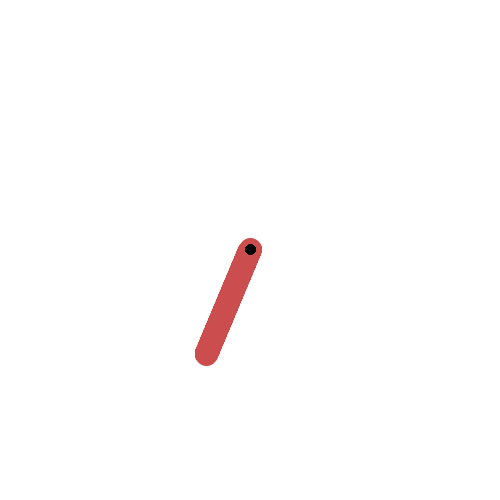

In [47]:
state, info = env.reset(seed=505)
for t in range(200):
    # clear frame
    display.clear_output(wait=True)

    action = agent.select_action(state)

    # render game
    frame = env.render()
    display.display(Image.fromarray(frame))
    time.sleep(0.05)

    state, reward, done, _, info = env.step(action)
    if done:
        break
        
env.close()

### 8. Train the Agent with DDPG

In [58]:
def ddpg(
    env,
    agent,
    n_episodes=1000,
    window=100,
    max_t=300
):
    """Deep Deterministic Policy Gradient.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        window (int): window size for computing average score
    """
    # list containing scores from each episode
    scores = []
    actor_losses = []
    critic_losses = []
    max_avg_score = -np.inf
    for i_episode in range(1, n_episodes + 1):
        
        # get init state
        state, _ = env.reset()
        agent.reset()
        
        # run each episode
        total_reward = 0
        total_critic_loss = 0
        total_actor_loss = 0
        for t in range(max_t):
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            loss = agent.step(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
            
            if loss:
                critic_loss, actor_loss = loss
                total_critic_loss += critic_loss.item()
                total_actor_loss += actor_loss.item()
        
        # save current episode total score    
        scores.append(total_reward)
        critic_losses.append(total_critic_loss)
        actor_losses.append(total_actor_loss)

        # Print episode stats
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)), end="")
        if len(scores) > window:
            avg_score = np.mean(scores[-window:])
            if avg_score > max_avg_score:
                max_avg_score = avg_score
                agent.save("best_checkpoint.pth")

        if i_episode % window == 0:
            print(
                "\rEpisode {}/{} | Max Average Score: {:.2f}".format(
                    i_episode, n_episodes, max_avg_score
                ),
            )

    agent.save("final_checkpoint.pth")
    return scores, actor_losses, critic_losses


In [59]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

agent = Agent(
	env,
	test_mode=False,
	hidden_size=(400, 300),
	buffer_size=int(1e6),
	batch_size=64,
	gamma=0.99,
	tau=1e-3,
	lr_actor=1e-4,
	lr_critic=1e-3,
    device=device,
	seed=42,
)

scores, actor_losses, critic_losses = ddpg(
    env,
    agent,
    n_episodes=1000,
    window=100,
    max_t=300
)

Episode 100/1000 | Max Average Score: -inf
Episode 200/1000 | Max Average Score: -949.55
Episode 300/1000 | Max Average Score: -899.91
Episode 400/1000 | Max Average Score: -899.91
Episode 500/1000 | Max Average Score: -702.20
Episode 600/1000 | Max Average Score: -494.45
Episode 700/1000 | Max Average Score: -315.48
Episode 800/1000 | Max Average Score: -315.48
Episode 900/1000 | Max Average Score: -315.48
Episode 1000/1000 | Max Average Score: -315.48


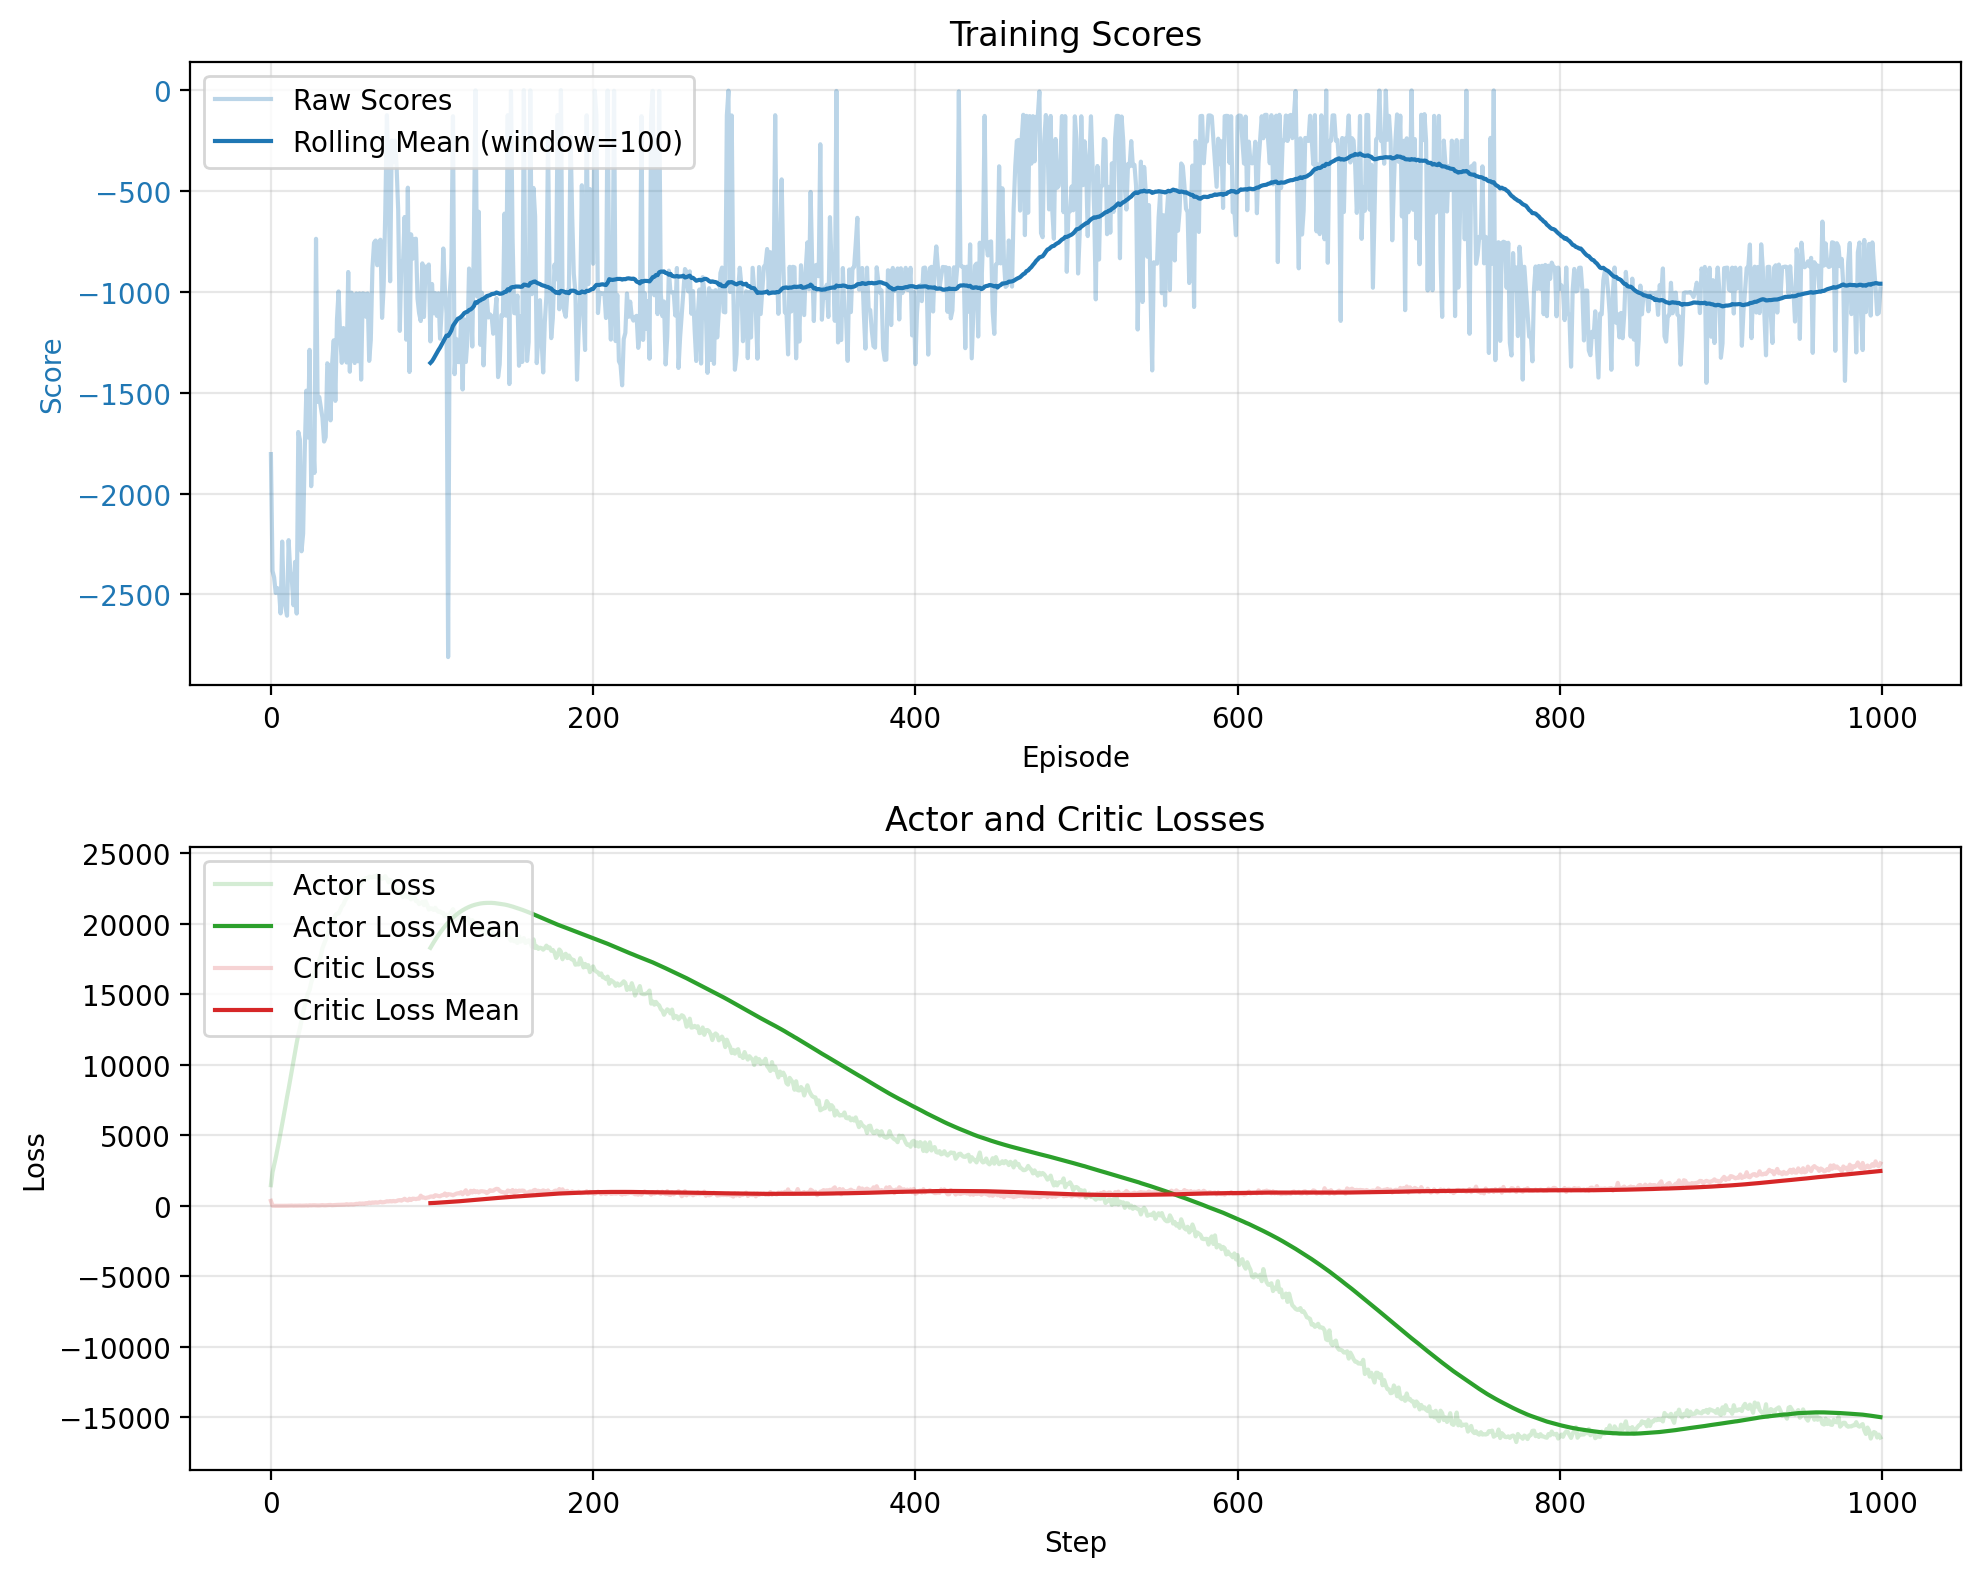

In [ ]:
from plot_utils import plot_scores

rolling_mean = plot_scores(
    scores=scores,
    actor_losses=actor_losses,
    critic_losses=critic_losses,
    rolling_window=100
)

### 9. Watch a Smart Agent!

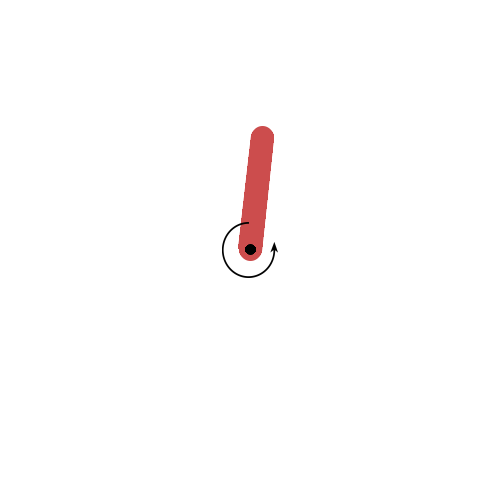

In [65]:
agent = Agent(
	env,
	test_mode=True,
    device=device
)

agent.load('best_checkpoint.pth')

state, info = env.reset(seed=505)
for t in range(200):
    # clear frame
    display.clear_output(wait=True)

    action = agent.select_action(state)

    # render game
    frame = env.render()
    display.display(Image.fromarray(frame))
    time.sleep(0.05)

    state, reward, done, _, info = env.step(action)
    if done:
        break
        
env.close()